## Baltic test case configuration
Diagnostics output to close heat, salt, thickness budgets, and derive watermass transformation.  
This notebook is a working space to explore that output.

In [4]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram

In [10]:
### Data loading, grabbed from MOM6-analysis cookbook
# Load data on native grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/tutorial_wmt/'
gridname = 'natv'
prefix = '19000101.ocean_'
# Diagnostics were saved into different files
suffixs = ['thck','heat','salt','surf','xtra']
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
gridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+gridname).squeeze()
# Specify constants for the reference density and the specific heat capacity
rho0 = 1035.
Cp = 3992.

In [33]:
# Specify the diffusive tendency terms
processes=['boundary forcing','vertical diffusion','neutral diffusion',
           'frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':'opottemppmdiff',
         'frazil ice':'frazil_heat_tendency',
         'internal heat':'internal_heat_heat_tendency'}
terms['salt'] = {'boundary forcing':'boundary_forcing_salt_tendency',
         'vertical diffusion':'osaltdiff',
         'neutral diffusion':'osaltpmdiff',
         'frazil ice':None,
         'internal heat':None}
terms['thck'] = {'boundary forcing':'boundary_forcing_h_tendency',
         'vertical diffusion':None,
         'neutral diffusion':None,
         'frazil ice':None,
         'internal heat':None}

colors = {'boundary forcing':'tab:blue',
         'vertical diffusion':'tab:orange',
         'neutral diffusion':'tab:green',
         'frazil ice':'tab:red',
         'internal heat':'tab:purple'}

***
11/11/20 gmac  
In equating the content tendency output by the model with the tendency of the materially conserved tracer (e.g. heat tendency and temperature), I think I am making an error by not accomodating changes in thickness. The product rule shows clearly that $h\dot{\lambda} \neq \dot{(h\lambda)}$, and it is the LHS that we wish to have in the WMT expression. Here, try applying a correction for $\lambda\dot{h}$.  
*[But, look again carefully at MOM5_elements, Eq. 36.87, equates the two. There is no thickness rate of change on the LHS. This is true due to continuity, **except** in the presence of a surface volume flux. This is what is then explored in Section 36.8.6.]* 

In [48]:
G_prior = xr.Dataset()
G = xr.Dataset()
budget = 'salt'

# Specify the tracer, its range and bin widths (\delta\lambda) for the calculation
if budget == 'heat':
    tracer = ds['temp']
    delta_l = 0.2
    lmin = -2
    lmax = 10
elif budget == 'salt':
    tracer = ds['salt']
    delta_l = 0.2
    lmin = 2
    lmax = 36
bins = np.arange(lmin,lmax,delta_l)

for process in processes:
    term = terms[budget][process]
    if term is not None:
        nanmask = np.isnan(ds[term])
        tendency = ds[term]
        if budget == 'heat':
            tendency /= Cp*rho0
        
        # Calculate G prior to thickness correction
        G_prior[process] = histogram(tracer.where(~nanmask).squeeze(),
                        bins=[bins],
                        dim=['xh','yh','zl'],
                        weights=(
                            rho0*(tendency
                                 )*grid['areacello']
                        ).where(~nanmask).squeeze()
                          )/np.diff(bins)
        
        # Accomodate thickness changes if nonzero
        term_thck = terms['thck'][process]
        if term_thck is not None:
            tendency -= tracer*ds[term_thck]
        
        G[process] = histogram(tracer.where(~nanmask).squeeze(),
                            bins=[bins],
                            dim=['xh','yh','zl'],
                            weights=(
                                rho0*(tendency
                                     )*grid['areacello']
                            ).where(~nanmask).squeeze()
                              )/np.diff(bins)

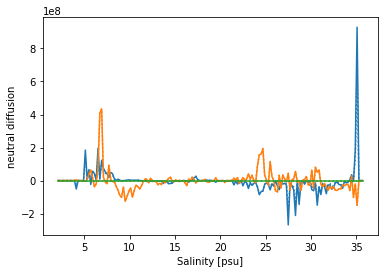

In [49]:
for process in G.data_vars:
        G_prior[process].plot(label=process,color=colors[process],linestyle=':')
        G[process].plot(label=process,color=colors[process])